# Introduction

# Data wrangling
During the import using MongoDBCompass, array type can't be imported, therefore artist_genres list representing the genres for an artist have been first imported as String and then converted into Array type in the way shown above.

In [ ]:
from pymongo import MongoClient
from bson import json_util

import matplotlib.pyplot as plt

client = MongoClient() # we run on localhost and default port
db     = client['spotify']
all    = db['all']
artists = db['artists']

In [ ]:

for doc in all.find():
    genresArray = doc['artist_genres'].replace('[', '').replace(']', '').split(', ')
    genresArray = [item.replace("'", '').strip() for item in genresArray]

    # Update the document in the collection
    all.update_one(
        {'_id': ObjectId(doc['_id'])},
        {'$set': {'artist_genres': genresArray}}
    )


## Dataset
The chosen dataset is taken from https://www.kaggle.com/datasets/tonygordonjr/spotify-dataset-2023.

It contains a cleaned version of the spotify content. The author engineered the content, removing inconsistencies from other Spotify source data.
Has 375k entries, each of them with 49 different values, representing various characteristics of the track, album artist and label (an extended explanation can be seen in the link above).



## Schema

In [ ]:
document = all.find_one()
types    = {}

for key, value in document.items():
    types[key] = str(type(value).__name__)

print(json_util.dumps(types, indent=2))

{
  "_id": "ObjectId",
  "album_id": "str",
  "album_name": "str",
  "album_popularity": "int",
  "album_type": "str",
  "artists": "str",
  "artist_0": "str",
  "artist_id": "str",
  "duration_sec": "float",
  "label": "str",
  "release_date": "datetime",
  "total_tracks": "int",
  "track_id": "str",
  "track_name": "str",
  "track_number": "int",
  "artist_genres": "list",
  "artist_popularity": "int",
  "followers": "int",
  "name": "str",
  "acousticness": "float",
  "analysis_url": "str",
  "danceability": "float",
  "duration_ms": "int",
  "energy": "float",
  "instrumentalness": "float",
  "key": "int",
  "liveness": "float",
  "loudness": "float",
  "mode": "int",
  "speechiness": "float",
  "tempo": "float",
  "time_signature": "int",
  "track_href": "str",
  "type": "str",
  "uri": "str",
  "valence": "float",
  "explicit": "bool",
  "track_popularity": "int",
  "release_year": "int",
  "release_month": "str",
  "rn": "int"
}


Utility function to display data and eventualy reduce the amount displayed, to make the content of the PDF readable.

In [ ]:
def display_results(res, cut_result = False):
    if (cut_result == True):
        for entry in res[0:20]:
            print(entry)
    else:
        for entry in res:
            print(entry)

def display_inner_results(res, cut_result = False, quantity = 20):
    if quantity < 0:
        quantity = 20
    keys = list(res[0].keys())
    for key in keys:
        print(f'\033[1m{key}\033[0m', end='\n\n')
        if (cut_result == True):
            for inner_entry in res[0][key][0:quantity]:
                print(inner_entry)
        else:
            for inner_entry in res[0][key]:
                print(inner_entry)
        print('')

## Query 1: Style the top 10 artists with the highest average album popularity after 2018

In [ ]:
all.create_index([("artist_id", 1)])

'artist_id_1'

In [ ]:
import datetime
artists = all.artists
query1 =  [
  {
    '$match': {
      'album_type': "album",
      'release_date': {'$gte': datetime.datetime(2018, 1, 1)}
    }
  },
  {
    '$group': {
      '_id': "$artist_id",
      'totalAlbums': {'$sum': 1},
      'averageAlbumPopularity': {'$avg': "$album_popularity"},
      'artist_name': {"$first": "$artists"}
    }
  },
  {
    '$match': {
      'totalAlbums': {'$gte': 4}
    }
  },
  {
    '$project': {
      '_id': 0,
      'artist_name': 1,
      'averageAlbumPopularity': 1
    }
  },
  {
    '$sort': {
      'averageAlbumPopularity': -1
    }
  },
  {
    '$limit': 10
  }
]

result_query1 = list(all.aggregate(query1))


In [ ]:
display_results(result_query1)

{'averageAlbumPopularity': 90.56, 'artist_name': "['Harry Styles']"}
{'averageAlbumPopularity': 90.0, 'artist_name': "['Mitski']"}
{'averageAlbumPopularity': 89.33962264150944, 'artist_name': "['Bad Bunny']"}
{'averageAlbumPopularity': 87.0, 'artist_name': "['The Neighbourhood']"}
{'averageAlbumPopularity': 86.0, 'artist_name': "['Troye Sivan']"}
{'averageAlbumPopularity': 85.0, 'artist_name': "['Billie Eilish']"}
{'averageAlbumPopularity': 85.0, 'artist_name': "['Offset', 'JID']"}
{'averageAlbumPopularity': 84.72340425531915, 'artist_name': "['Imagine Dragons']"}
{'averageAlbumPopularity': 84.0, 'artist_name': "['Olivia Rodrigo']"}
{'averageAlbumPopularity': 84.0, 'artist_name': "['Zé Neto & Cristiano']"}


## Query 2: Evolution of song's explicitness over the years (from 1960 on)
Indexes were created to speed up a such heavy query. Without indexes the result couldn't be observed due to the long execution time needed.

In [ ]:
all.create_index([( "track_id", 1 )])
all.create_index([( "release_date", 1 )])

'release_date_1'

In [ ]:
query_2 = [
    {
        '$match': {
            'album_type': "album",
            'release_date': {'$gte': datetime.datetime(1960, 1, 1)}
        }
    },
    {
        '$group': {
            '_id': {
                'year': {'$year': '$release_date'},
                'explicit': '$explicit'
            },
            'totalTracks': {'$sum': 1}
        }
    },
    {
        '$group': {
            '_id': '$_id.year',
            'explicitCount': {
                '$sum': {
                    '$cond': [{'$eq': ['$_id.explicit', True]}, '$totalTracks', 0]
                }
            },
            'totalTracks': {'$sum': '$totalTracks'}
        }
    },
    {
        '$project': {
            '_id': 0,
            'year': '$_id',
            'explicitPercentage': {
                '$multiply': [
                    {'$divide': ['$explicitCount', '$totalTracks']},
                    100
                ]
            }
        }
    },
    {
        '$sort': {'year': 1}
    }
]

result_query2 = list(all.aggregate(query_2))

In [ ]:
display_results(result_query2)

{'year': 1960, 'explicitPercentage': 0.0}
{'year': 1961, 'explicitPercentage': 0.0}
{'year': 1962, 'explicitPercentage': 0.0}
{'year': 1963, 'explicitPercentage': 0.0}
{'year': 1964, 'explicitPercentage': 0.0}
{'year': 1965, 'explicitPercentage': 0.0}
{'year': 1966, 'explicitPercentage': 0.0}
{'year': 1967, 'explicitPercentage': 0.0}
{'year': 1968, 'explicitPercentage': 0.0}
{'year': 1969, 'explicitPercentage': 0.0}
{'year': 1970, 'explicitPercentage': 0.0}
{'year': 1971, 'explicitPercentage': 0.1941747572815534}
{'year': 1972, 'explicitPercentage': 0.0}
{'year': 1973, 'explicitPercentage': 0.34071550255536626}
{'year': 1974, 'explicitPercentage': 0.0}
{'year': 1975, 'explicitPercentage': 0.3395585738539898}
{'year': 1976, 'explicitPercentage': 0.0}
{'year': 1977, 'explicitPercentage': 0.0}
{'year': 1978, 'explicitPercentage': 0.22522522522522523}
{'year': 1979, 'explicitPercentage': 0.47095761381475665}
{'year': 1980, 'explicitPercentage': 0.8298755186721992}
{'year': 1981, 'explicitP

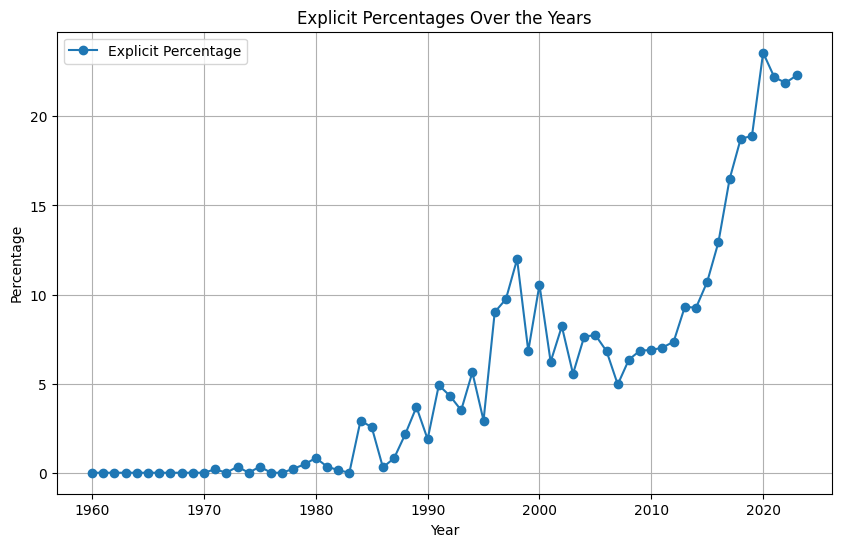

In [ ]:
years                = [entry['year']               for entry in result_query2]
explicit_percentages = [entry['explicitPercentage'] for entry in result_query2]

plt.figure(figsize=(10, 6))
plt.plot(years, explicit_percentages, label='Explicit Percentage', marker='o')

plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Explicit Percentages Over the Years')
plt.legend()
plt.grid(True)
plt.show()

## Query 3: get the average features of the tracks based on its time signature

In [ ]:
query3 = [
    {
        '$group': {
            '_id': '$time_signature',
            'average_danceability': {'$avg': '$danceability'},
            'average_energy': {'$avg': '$energy'},
            'average_valence': {'$avg': '$valence'}
        }
    },
    {
        '$sort': {
            '_id': 1
        }
    },
    {
        '$project': {
            '_id': 0,
            'time_signature': '$_id',
            'average_danceability': 1,
            'average_energy': 1,
            'average_valence': 1
        }
    }
]

result_query3 = list(all.aggregate(query3))

In [ ]:
display_results(result_query3)

{'average_danceability': 0.0025912408759124084, 'average_energy': 0.2642535627737226, 'average_valence': 0.001588868613138686, 'time_signature': 0}
{'average_danceability': 0.41776983736762485, 'average_energy': 0.3703698709341906, 'average_valence': 0.3174133080559758, 'time_signature': 1}
{'average_danceability': 0.4430313164594878, 'average_energy': 0.3577192962932455, 'average_valence': 0.3386356197294194, 'time_signature': 3}
{'average_danceability': 0.5964398588798588, 'average_energy': 0.5534134305153405, 'average_valence': 0.476209640001575, 'time_signature': 4}
{'average_danceability': 0.450119538349691, 'average_energy': 0.3950980574427481, 'average_valence': 0.3200791159578335, 'time_signature': 5}


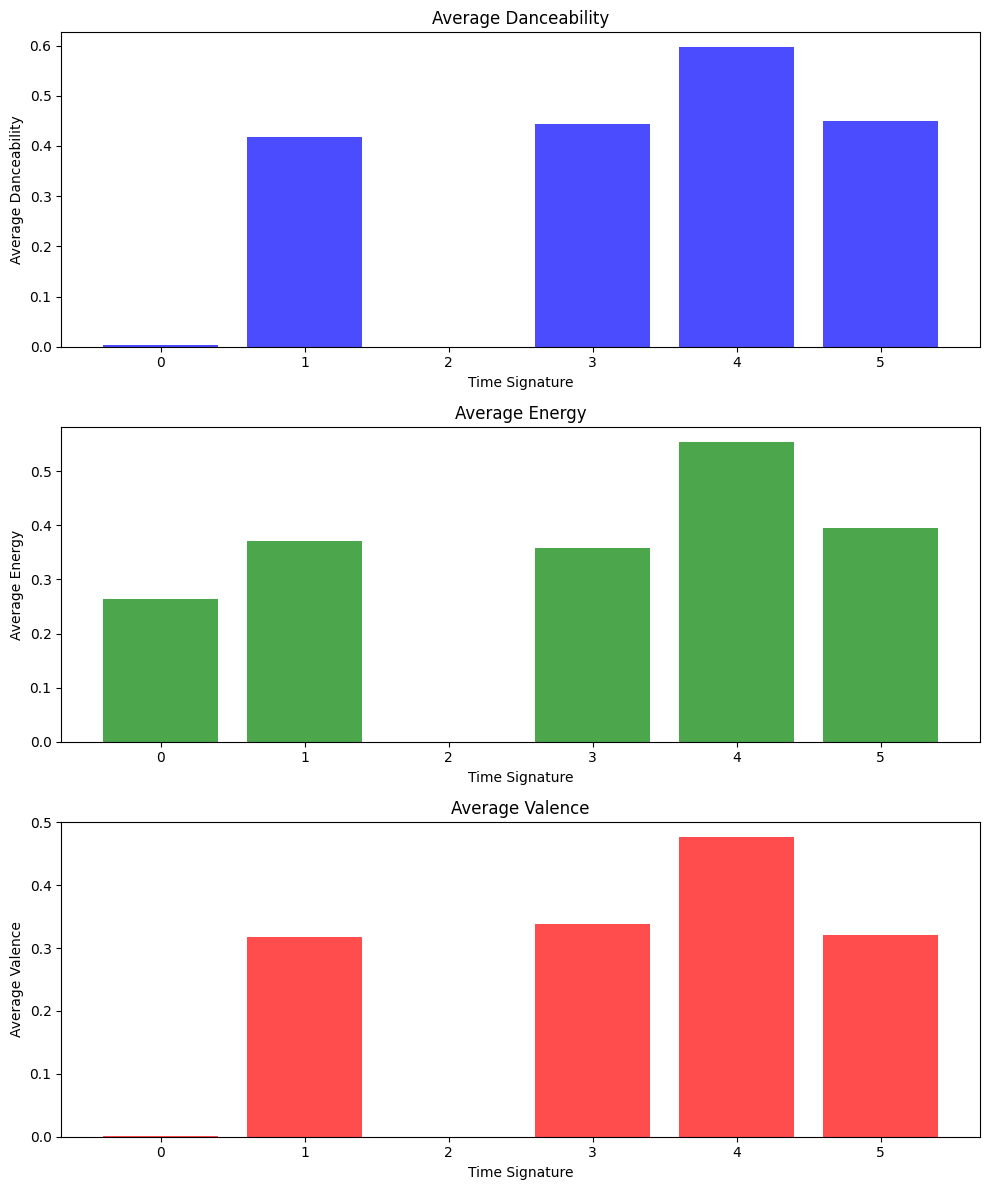

In [ ]:
danceability    = [entry['average_danceability'] for entry in result_query3]
energy          = [entry['average_energy'] for entry in result_query3]
valence         = [entry['average_valence'] for entry in result_query3]
time_signatures = [entry['time_signature'] for entry in result_query3]

# Plotting histograms
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot for Average Danceability
axs[0].bar(time_signatures, danceability, color='blue', alpha=0.7)
axs[0].set_title('Average Danceability')
axs[0].set_xlabel('Time Signature')
axs[0].set_ylabel('Average Danceability')

# Plot for Average Energy
axs[1].bar(time_signatures, energy, color='green', alpha=0.7)
axs[1].set_title('Average Energy')
axs[1].set_xlabel('Time Signature')
axs[1].set_ylabel('Average Energy')

# Plot for Average Valence
axs[2].bar(time_signatures, valence, color='red', alpha=0.7)
axs[2].set_title('Average Valence')
axs[2].set_xlabel('Time Signature')
axs[2].set_ylabel('Average Valence')

plt.tight_layout()
plt.show()

### Interpretation:
We can see that 4/4 is the time signature with best musical features. That may be the reason of why it is the most used signature in commercial music.

But also, the 3/4 is the Walzer's signature and the danceability is not really high. We don't really know how reliable are this features, but apparently the danceability of Walzer is considered lower than modern music.

## Query 4: find artists popular only in few albums
Useful for instance if you want to find underground artists that collaborate with big stars.Very likely in those album the one with low popularity will have a big album popularity in that album. Useful also to spot artists that, for instance, wrote a summer-hit but for the rest of the year no one listen to him. Or, artists that had success with an album but not on the whole carrier. Or again, artists that found success only after some period. The query works by finding the stardard deviation of the artist's albums popularity. Artists that wrote less than 3 albums were discarted.

Also album with lowest popularity for each artist weren't counted (it can be their first album) to be more optimistic.

In [ ]:
query_4 = [
    {
        "$group": {
            "_id": "$name",
            "numAlbums": {"$sum": 1},
            "popularityArray": {"$push": {"popularity": "$album_popularity", "album_id": "$album_id", "album_name": "$album_name"}}
        }
    },
    {
        "$match": {
            "numAlbums": {"$gt": 3}  # Exclude artists with less than 3 albums
        }
    },
    {
        "$unwind": "$popularityArray"
    },
    {
        "$sort": {"popularityArray.popularity": 1}
    },
    {
        "$group": {
            "_id": "$_id",
            "popularityArray": {"$push": "$popularityArray"},
            "maxAlbumPopularity": {"$last": "$popularityArray"},
            "avgPopularity": {"$avg": "$popularityArray.popularity"},
            "stdDevPopularity": {"$stdDevPop": "$popularityArray.popularity"}
        }
    },
    {
         '$project': {
            'popularityArray': 0,
             'maxAlbumPopularity':{'album_id':       0}
        }
    },
    {
        "$sort": {"stdDevPopularity": -1}
    },
    {
        "$limit": 10
    }
]
result_query4 = list(all.aggregate(query_4))

In [ ]:
display_results(result_query4)

{'_id': 'Amit Trivedi', 'maxAlbumPopularity': {'popularity': 65, 'album_name': 'Dear Zindagi (Original Motion Picture Soundtrack)'}, 'avgPopularity': 44.0, 'stdDevPopularity': 29.698484809834994}
{'_id': 'Red Velvet', 'maxAlbumPopularity': {'popularity': 73, 'album_name': 'Chill Kill - The 3Rd Album'}, 'avgPopularity': 34.934707903780065, 'stdDevPopularity': 28.042294973644843}
{'_id': 'Lynyrd Skynyrd', 'maxAlbumPopularity': {'popularity': 75, 'album_name': 'Second Helping (Expanded Edition)'}, 'avgPopularity': 49.8, 'stdDevPopularity': 27.85964823898536}
{'_id': 'Chris Brown', 'maxAlbumPopularity': {'popularity': 86, 'album_name': '11:11'}, 'avgPopularity': 42.50355329949239, 'stdDevPopularity': 26.64948714401531}
{'_id': 'Simon Franglen', 'maxAlbumPopularity': {'popularity': 63, 'album_name': 'Avatar: The Way Of Water (Original Motion Picture Soundtrack)'}, 'avgPopularity': 48.03448275862069, 'stdDevPopularity': 26.53102641556666}
{'_id': 'Metro Boomin', 'maxAlbumPopularity': {'popul

### Interpretation:
The first artist named Amit Trivedi isn't famous. However, wrote a soundrack for a movie. This rised his popularity's standard deviation.
We can see also Lynyrd Skynyrd, whose most famous album is the one containing Sweet Home Alabama.


![immagine.png](attachment:326ee54b-bc73-4246-8d42-bd13909d2610.png)


A trend that can be seen is that Soundrack Movie Albums skyrocket the popularity of artists.

# Query 5: Most important labels for each genre

In [ ]:
query_5 =  [
    {
        "$unwind": "$artist_genres",
    },
    {
        "$group": {
            "_id": {
                "genre": "$artist_genres",
                "label": "$label",
            },
            "averagePopularity": {"$avg": "$album_popularity"},
        },
    },
    {
        "$sort": {
            "_id.genre": 1,
            "averagePopularity": -1,
        },
    },
    {
        "$group": {
            "_id": "$_id.label",
            "genres": {"$push": {"genre": "$_id.genre", "popularity": "$averagePopularity"}},
        },
    },
    {
        "$project": {
            "_id": 0,
            "mostImportantLabel": "$_id",
            "highestAveragePopularity": {"$max": "$genres.popularity"},
            "genres": "$genres.genre",
        },
    },
    {
        "$sort": {
            "highestAveragePopularity": -1,
        },
    },
    {
        "$limit": 50
    }
]


result_query5 = list(all.aggregate(query_5))

In [ ]:
display_results(result_query5, True)

{'mostImportantLabel': 'Dead Oceans', 'highestAveragePopularity': 90.0, 'genres': ['brooklyn indie', 'indie pop', 'la indie', 'pov: indie']}
{'mostImportantLabel': 'Cash Money/Drake LP6', 'highestAveragePopularity': 87.0, 'genres': ['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap']}
{'mostImportantLabel': 'Slaughter Gang, LLC/Epic/Boominati Worldwide/Republic', 'highestAveragePopularity': 86.0, 'genres': ['atl hip hop', 'hip hop', 'rap']}
{'mostImportantLabel': 'Street Mob Records - Rancho Humilde', 'highestAveragePopularity': 85.0, 'genres': ['corrido', 'corridos tumbados', 'sad sierreno', 'sierreno']}
{'mostImportantLabel': 'Rimas Entertainment LLC', 'highestAveragePopularity': 84.65891472868218, 'genres': ['bachata', 'bachata dominicana', 'latin hip hop', 'latin pop', 'reggaeton', 'reggaeton flow', 'trap boricua', 'trap latino', 'trap triste', 'tropical', 'urbano latino']}
{'mostImportantLabel': 'Kid Ina Korner / Interscope', 'highestAveragePopularity': 84.10416666666

### Show the 10 most important labels based only on the popularity

In [ ]:
labels = [entry['mostImportantLabel'] for entry in result_query5 if 'genres' in entry]
average_popularities = [entry['highestAveragePopularity'] for entry in result_query5 if 'genres' in entry]
labels = labels[0:10]
average_popularities = average_popularities[0:10]

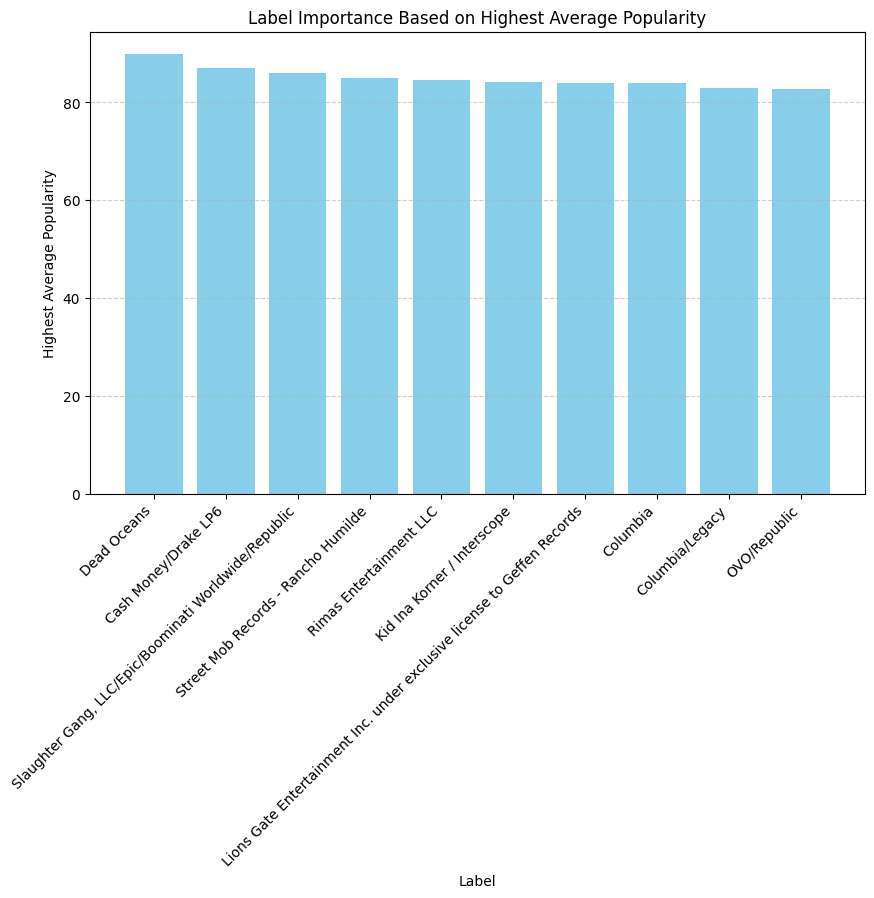

In [ ]:

# Plotting as a histogram
plt.figure(figsize=(10, 6))
plt.bar(labels, average_popularities, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Highest Average Popularity')
plt.title('Label Importance Based on Highest Average Popularity')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

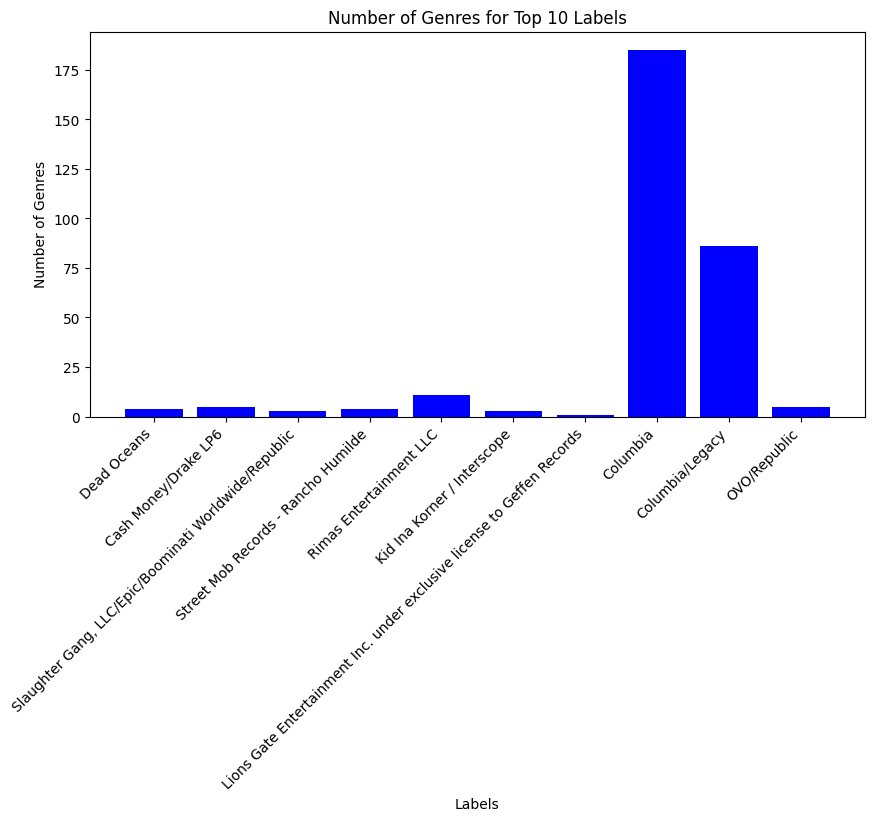

In [ ]:
genres_count = [len(entry['genres']) for entry in result_query5[:10]]
# Plot the number of genres for each label
plt.figure(figsize=(10, 5))
plt.bar(labels, genres_count, color='blue')
plt.xlabel('Labels')
plt.ylabel('Number of Genres')
plt.title('Number of Genres for Top 10 Labels')
plt.xticks(rotation=45, ha='right')
plt.show()

### Interpretation:
Dead Ocean is the Mitski's label, that is one of the artist with highest popularity.
Cash Money is the label of Lil Wayne (in the gold era), Nicki Minaj, Drake and Chris Brown and others.

We believe that Dead Ocean is more important than Cash Money because has fewer artists but are all popular in the same way, instead Dead Money has lots of famous arists, but that have faced periods with high popularity alternated to periods with lower popularity. Letting them scale to the 2nd position.

Indeed, Dead Ocean was born in 2007, while Cash Money in 1991.

Another interesting factor is the amount of genres that labels have. In the second plot can be seen that the famous Columbia is way more versatile than others. And this can influence in the fact that is the more known by non expert in the field.

A next analysis is conducted down here by taking in consideration for the 70% of the score the popularity and for the 30% the versatility of the labels (in terms of genres).



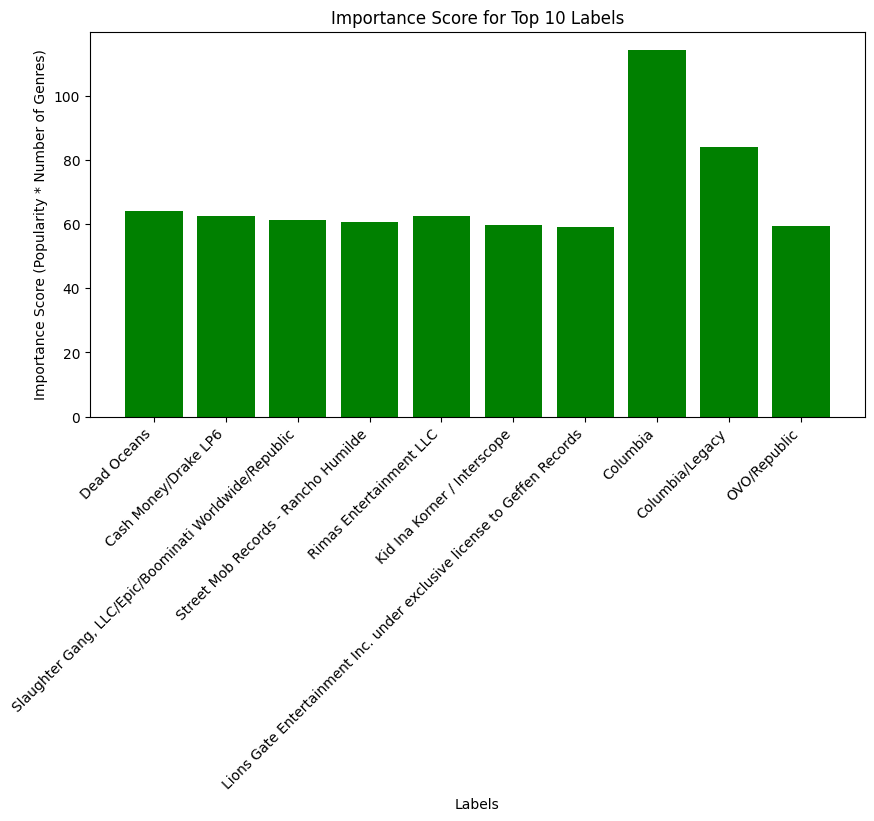

In [ ]:
importance_scores = [(entry['highestAveragePopularity']*0.7) + (len(entry['genres'])*0.3) for entry in result_query5[:10]]
# Plot the importance scores for each label
plt.figure(figsize=(10, 5))
plt.bar(labels, importance_scores, color='green')
plt.xlabel('Labels')
plt.ylabel('Importance Score (Popularity * Number of Genres)')
plt.title('Importance Score for Top 10 Labels')
plt.xticks(rotation=45, ha='right')
plt.show()


## Query 6: find label that release albums prevelently (more than 65%) in the summer

In [ ]:
query_6 = [
    {
        '$match': {
            'artist_genres.0': {'$ne': ''}  # Exclude documents where the first element of artist_genres is an empty string
        }
    },
    {
        '$group': {
            '_id': {
                'label': '$label',
                'album_name': '$album_name',
                'release_date': '$release_date'
            },
            'totalAlbums': {'$sum': 1},
            'summerAlbums': {
                '$max': {
                    '$cond': [
                        {
                            '$or': [
                                {'$eq': [{'$month': '$release_date'}, 6]},  # June
                                {'$eq': [{'$month': '$release_date'}, 7]}   # July
                            ]
                        },
                        1,
                        0
                    ]
                }
            },
            'artistGenres': {'$push': '$artist_genres'}
        }
    },
    {
        '$group': {
            '_id': {
                'label': '$_id.label'
            },
            'totalAlbums': {'$sum': '$totalAlbums'},
            'summerAlbums': {'$sum': '$summerAlbums'},
            'artistGenres': {'$first': '$artistGenres'}
        }
    },
    {
        '$project': {
            'label': '$_id.label',
            'totalAlbums': 1,
            'summerAlbums': 1,
            'percentageInSummer': {
                '$multiply': [{'$divide': ['$summerAlbums', '$totalAlbums']}, 100]
            },
            'artistGenres': 1  # New line to include artist genres in the output
        }
    },
    {
        '$match': {
            '$and': [
                {'totalAlbums': {'$gt': 5}},  # labels with at least 8 total albums
                {'percentageInSummer': {'$gte': 60}},
            ]
        }
    }
    ,
    {
        '$project': {
            'label': 1,
            'totalAlbums': 1,
            'summerAlbums': 1,
            'percentageInSummer': 1,
            'artistGenres': 1  # New line to include artist genres in the final output
        }
    },
    {
        '$sort': {'percentageInSummer': -1}
    }
]

result_query6 = list(all.aggregate(query_6))

In [ ]:
display_results(result_query6)

{'_id': {'label': 'KARAOKE KARAOKE KARAOKE'}, 'totalAlbums': 20, 'summerAlbums': 13, 'artistGenres': [['karaoke']], 'label': 'KARAOKE KARAOKE KARAOKE', 'percentageInSummer': 65.0}


### Interpretation
During summer time karaoke is played by villages. So it is reasonable.
One would expect reggeaton, but maybe reggeaton's labels do also other genres, therefore can't be spotted.

# Query 7: Average song name length for each genre

In [ ]:
all.create_index([( "artist_genres", 1 )])

'artist_genres_1'

In [ ]:
query_7=[
    {
        "$unwind": "$artist_genres"
    },
    {
        "$group": {
            "_id": {
                "genre": "$artist_genres",
                "artist_id": "$artist_id"
            },
            "avgTrackNameLength": {
                "$avg": {"$strLenCP": "$track_name"}
            },
            "avgWordsPerTrack": {
                "$avg": {
                    "$size": {"$split": ["$track_name", " "]}
                }
            }
        }
    },
    {
        "$group": {
            "_id": "$_id.genre",
            "artistCount": {"$sum": 1},
            "avgTrackNameLength": {"$avg": "$avgTrackNameLength"},
            "avgWordsPerTrack": {"$avg": "$avgWordsPerTrack"}
        }
    },
    {
        "$match": {
            "artistCount": {"$gte": 5}
        }
    },
    {
        "$sort": {
            "avgTrackNameLength": -1
        }
    },
    {
        "$project": {
            "genre": "$_id",
            "avgTrackNameLength": 1,
            "avgWordsPerTrack": 1,
            "_id": 0
        }
    }
]



result_query7 = list(all.aggregate(query_7))

In [ ]:
print("Genres with highest track name length (with at least 5 artists):")
display_results(result_query7[:10])
print("\nGenres with lowest track name length (with at least 5 artists):")
display_results(result_query7[-10:])

Genres with highest track name length (with at least 5 artists):
{'avgTrackNameLength': 68.11736713499259, 'avgWordsPerTrack': 12.199915984458721, 'genre': 'early romantic era'}
{'avgTrackNameLength': 65.61300979809559, 'avgWordsPerTrack': 12.120837070193797, 'genre': 'classical era'}
{'avgTrackNameLength': 65.2653526947619, 'avgWordsPerTrack': 11.772012509515514, 'genre': 'german baroque'}
{'avgTrackNameLength': 63.65416278868092, 'avgWordsPerTrack': 11.83798962679043, 'genre': 'german romanticism'}
{'avgTrackNameLength': 60.54591567265084, 'avgWordsPerTrack': 9.812043454610988, 'genre': 'karaoke'}
{'avgTrackNameLength': 59.86873675529788, 'avgWordsPerTrack': 10.172023476323757, 'genre': 'orchestral performance'}
{'avgTrackNameLength': 59.836212495109095, 'avgWordsPerTrack': 10.672447078200568, 'genre': 'russian romanticism'}
{'avgTrackNameLength': 59.45189808826172, 'avgWordsPerTrack': 9.953272396454215, 'genre': 'italian opera'}
{'avgTrackNameLength': 58.131064039939176, 'avgWordsPe

### Interpretation:
Oldest songs and classical ones have long names, because they contains tipically the modality in which they are played, the collection and sometimes the orchestra. For instance: "Cello Suite No. 1 in G Major BWV1007" is a very long name.
On the other hand, genres with lowest track name are the one from the asian countries, where the alphababet compress the lenght of the names.
## Query 8: find the average duration for tracks based on their tempo class

In [ ]:
query_8 = [
    {
        "$project": {
            "tempo_class": {
                "$switch": {
                    "branches": [
                        {"case": {"$and": [{"$lt": ["$tempo", 48]}, {"$gte": ["$tempo", 44]}]}, "then": "LARGO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 52]}, {"$gte": ["$tempo", 48]}]}, "then": "LENTO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 56]}, {"$gte": ["$tempo", 52]}]}, "then": "ADAGIO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 60]}, {"$gte": ["$tempo", 56]}]}, "then": "LARGHETTO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 66]}, {"$gte": ["$tempo", 60]}]}, "then": "ADAGIETTO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 72]}, {"$gte": ["$tempo", 66]}]}, "then": "ANDANTE"},
                        {"case": {"$and": [{"$lt": ["$tempo", 80]}, {"$gte": ["$tempo", 72]}]}, "then": "ANDANTINO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 96]}, {"$gte": ["$tempo", 88]}]}, "then": "MODERATO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 112]}, {"$gte": ["$tempo", 96]}]}, "then": "ALLEGRETTO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 126]}, {"$gte": ["$tempo", 112]}]}, "then": "ANIMATO"},
                        {"case": {"$and": [{"$lt": ["$tempo", 140]}, {"$gte": ["$tempo", 126]}]}, "then": "ASSAI"},
                        {"case": {"$and": [{"$lt": ["$tempo", 176]}, {"$gte": ["$tempo", 140]}]}, "then": "VIVACE"},
                        {"case": {"$gte": ["$tempo", 176]}, "then": "PRESTISSIMO"},
                    ],
                    "default": "SLOWEST TIMES"
                }
            },
            "duration_minutes": {"$divide": ["$duration_ms", 60000]}
        }
    },
    {
        "$group": {
            "_id": "$tempo_class",
            "avg_duration": {"$avg": "$duration_minutes"}
        }
    },
    {
        "$project": {
            "tempo_class": "$_id",
            "avg_duration": 1,
            "_id": 0
        }
    }
]

result_query8 = list(all.aggregate(query_8))

In [ ]:
display_results(result_query8)

{'avg_duration': 3.5537798512678807, 'tempo_class': 'ALLEGRETTO'}
{'avg_duration': 3.8230575639599556, 'tempo_class': 'ASSAI'}
{'avg_duration': 3.3695558965652346, 'tempo_class': 'PRESTISSIMO'}
{'avg_duration': 3.4778735171207127, 'tempo_class': 'VIVACE'}
{'avg_duration': 3.356519298245614, 'tempo_class': 'LARGHETTO'}
{'avg_duration': 3.5251283122176393, 'tempo_class': 'ANDANTE'}
{'avg_duration': 3.473595258830664, 'tempo_class': 'MODERATO'}
{'avg_duration': 3.415199651571823, 'tempo_class': 'SLOWEST TIMES'}
{'avg_duration': 3.5604190239551476, 'tempo_class': 'ANDANTINO'}
{'avg_duration': 3.306522016153156, 'tempo_class': 'ADAGIETTO'}
{'avg_duration': 2.4351985267034992, 'tempo_class': 'LARGO'}
{'avg_duration': 2.637751031353135, 'tempo_class': 'LENTO'}
{'avg_duration': 3.2373609375, 'tempo_class': 'ADAGIO'}
{'avg_duration': 3.763146843801568, 'tempo_class': 'ANIMATO'}


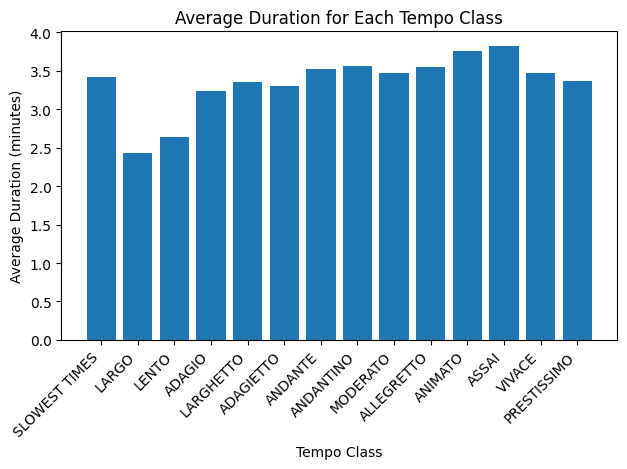

In [ ]:

# Order of tempos increasing
tempo_order = [
    "SLOWEST TIMES",
    "LARGO",
    "LENTO",
    "ADAGIO",
    "LARGHETTO",
    "ADAGIETTO",
    "ANDANTE",
    "ANDANTINO",
    "MODERATO",
    "ALLEGRETTO",
    "ANIMATO",
    "ASSAI",
    "VIVACE",
    "PRESTISSIMO"
]


def tempo_order_index(item):
    return tempo_order.index(item['tempo_class'])

# Sort with time increasing
result_query8 = sorted(result_query8, key=tempo_order_index)




tempo_classes = [doc["tempo_class"] for doc in result_query8]
avg_durations = [doc["avg_duration"] for doc in result_query8]

plt.bar(tempo_classes, avg_durations)
plt.xlabel('Tempo Class')
plt.ylabel('Average Duration (minutes)')
plt.title('Average Duration for Each Tempo Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

### Interpretation
Slowest times don't correspond to shorter tracks. At least not in every case.
But is found out that for LARGO and LENTO, which are very low bpm's tracks this is true.
We noticed instead that for ASSAI, which correpond to 126-140 bpms, longer tracks lives.
Typical genres in this range can be also techno, trance, dance-pop, drum and bass. For which correspond longer tracks.

# Query 9: given an artist find other similar artists

For each artist, average features of their songs have been calculated and stored in an intermediate collection for the sake fo simplicity.

In a second stage, given an artist, we want to find similar artist based on their features.

We chose to not consider the genre to be agnostic and not dependent of the classification of genres performed by others.

In [ ]:
query_9_intermediate =[
    {
        "$match":{
            "artist_popularity": {"$gt": 20}
        }
    },
    {
        "$group": {
            "_id": "$artist_id",
            "artist_name": {"$first": "$artist_0"},
            "avg_energy": {"$avg": "$energy"},
            "avg_key": {"$avg": "$key"},
            "avg_mode": {"$avg": "$mode"},
            "avg_instrumentalness": {"$avg": "$instrumentalness"},
            "avg_speechiness": {"$avg": "$speechiness"},
            "avg_tempo": {"$avg": "$tempo"}
        }
    }
]


result_query9_intermediate = list(all.aggregate(query_9_intermediate, allowDiskUse=True))

In [ ]:
display_results(result_query9_intermediate, True)

{'_id': '2oIQCM7hRZI9tS5b9S8rj4', 'artist_name': 'Tyler ICU', 'avg_energy': 0.504, 'avg_key': 1.0, 'avg_mode': 1.0, 'avg_instrumentalness': 0.0139, 'avg_speechiness': 0.0534, 'avg_tempo': 112.995}
{'_id': '2MbY32LPINIi9P6PCkrOJI', 'artist_name': 'MC4D', 'avg_energy': 0.819, 'avg_key': 6.0, 'avg_mode': 1.0, 'avg_instrumentalness': 0.0, 'avg_speechiness': 0.0518, 'avg_tempo': 128.083}
{'_id': '1nSpOxq3pcgomrfpXudQuq', 'artist_name': 'Kirk Knight', 'avg_energy': 0.798, 'avg_key': 2.0, 'avg_mode': 1.0, 'avg_instrumentalness': 0.0, 'avg_speechiness': 0.345, 'avg_tempo': 95.79}
{'_id': '1RulmpMDhjAPg9gx6tAzw9', 'artist_name': 'Deep Meditation Sleep', 'avg_energy': 0.14322313636363637, 'avg_key': 4.454545454545454, 'avg_mode': 0.4772727272727273, 'avg_instrumentalness': 0.9165454545454547, 'avg_speechiness': 0.044543181818181815, 'avg_tempo': 99.45331818181818}
{'_id': '4mPGfSPaje7KyKXNlBosQ9', 'artist_name': 'Flesh-n-Bone', 'avg_energy': 0.6529642857142858, 'avg_key': 5.392857142857143, 'avg

In [ ]:
db.AverageFeatures.insert_many(result_query9_intermediate)

We want to find similar artist to Eminem. So take its features from the intermediate collection:

In [ ]:
reference_artist_name = "Eminem"


# Find the reference artist's average values
reference_artist = db.AverageFeatures.find_one({"artist_name": reference_artist_name})

avg_instrumentalness_reference = reference_artist["avg_instrumentalness"]
avg_energy_reference           = reference_artist["avg_energy"]
avg_key_reference              = reference_artist["avg_key"]
avg_mode_reference             = reference_artist["avg_mode"]
avg_speech_reference           = reference_artist["avg_speechiness"]
avg_tempo_reference           = reference_artist["avg_tempo"]

In [ ]:
reference_artist

{'_id': '4utLUGcTvOJFr6aqIJtYWV',
 'artist_name': 'Eminem',
 'avg_energy': 0.7597499999999999,
 'avg_key': 4.0,
 'avg_mode': 0.5,
 'avg_instrumentalness': 0.0,
 'avg_speechiness': 0.17675000000000002,
 'avg_tempo': 145.46775}

In [ ]:
energy_range           = 0.05
key_range              = 1
mode_range             = 1
instrumentalness_range = 0.01
speech_range           = 0.01
tempo_range            = 5
# Query for artists with comparable average values
comparable_artists = list(db.Intermediate.find({
    "avg_tempo":            {"$gte": avg_tempo_reference - tempo_range, "$lte": avg_tempo_reference + tempo_range},
    "avg_speechiness":      {"$gte": avg_speech_reference - speech_range, "$lte": avg_speech_reference + speech_range},
    "avg_instrumentalness": {"$gte": avg_instrumentalness_reference - instrumentalness_range, "$lte": avg_instrumentalness_reference + instrumentalness_range},
    "avg_energy":           {"$gte": avg_energy_reference - energy_range, "$lte": avg_energy_reference + energy_range},
    "avg_key":              {"$gte": avg_key_reference - key_range, "$lte": avg_key_reference + key_range},
    "avg_mode":             {"$gte": avg_mode_reference - mode_range, "$lte": avg_mode_reference + mode_range},
}))

In [ ]:
comparable_artists

[{'_id': '6URykZzv72st8HDMcJNrsV',
  'artist_name': 'Dim4ou',
  'avg_energy': 0.762,
  'avg_key': 5.0,
  'avg_mode': 0.0,
  'avg_instrumentalness': 0.00191,
  'avg_speechiness': 0.173,
  'avg_tempo': 150.051}]

## Interpretation
A similar artist is found!
By listening to Dim4ou we found out that is VERY similar to Eminem, except for the fact that is russian.

Listen to prove: https://open.spotify.com/intl-it/track/29IcZyAxghfcYzIt1MeYEQ
# Query 10: average bpm evolution of genres over years
We wanted to explore how genres change over the years, by looking at how to tempo increase or decrese.

In [ ]:
query_10 =[
    {'$unwind': '$artist_genres'},
    {
        '$group': {
            '_id': {
                'year': {'$year': '$release_date'},
                'genre': '$artist_genres'
            },
            'average_tempo': {'$avg': '$tempo'}
        }
    },
    {
        '$sort': {'_id.year': 1}
    },
    {
        '$group': {
            '_id': '$_id.genre',
            'evolution': {
                '$addToSet': {
                    'year': '$_id.year',
                    'average_tempo': '$average_tempo'
                }
            }
        }
    },
    {
        '$project': {
            '_id': 0,
            'genre': '$_id',
            'evolution': 1
        }
    },
    {
        '$unwind': '$evolution'
    },
    {
        '$sort': {'evolution.year': 1}
    },
    {
        '$group': {
            '_id': '$genre',
            'evolution': {'$push': '$evolution'}
        }
    }
]


# Execute the aggregation pipeline
result_query10 = list(db.all.aggregate(query_10))

In [ ]:
display_results(result_query10, True)

{'_id': 'brockton hip hop', 'evolution': [{'year': 2019, 'average_tempo': 99.19919999999999}, {'year': 2020, 'average_tempo': 124.992875}, {'year': 2021, 'average_tempo': 140.075}, {'year': 2023, 'average_tempo': 114.97435714285714}]}
{'_id': 'soukous', 'evolution': [{'year': 1980, 'average_tempo': 116.09116666666667}, {'year': 2017, 'average_tempo': 102.02850000000001}]}
{'_id': 'schweizer rap', 'evolution': [{'year': 2017, 'average_tempo': 123.8826}, {'year': 2018, 'average_tempo': 113.449625}, {'year': 2019, 'average_tempo': 121.82900000000001}, {'year': 2020, 'average_tempo': 117.71906249999999}, {'year': 2021, 'average_tempo': 108.71761538461539}, {'year': 2022, 'average_tempo': 119.08500000000001}, {'year': 2023, 'average_tempo': 102.27892}]}
{'_id': 'canadian punk', 'evolution': [{'year': 2002, 'average_tempo': 156.27866666666668}, {'year': 2006, 'average_tempo': 140.7512142857143}, {'year': 2007, 'average_tempo': 127.54492857142857}, {'year': 2013, 'average_tempo': 113.32360000

### We filter the genres that have the linear regression coefficient higher (in module) than 0.6, represeting the genres with biggest bpm change in the years.

0.6731020517752355
lullaby


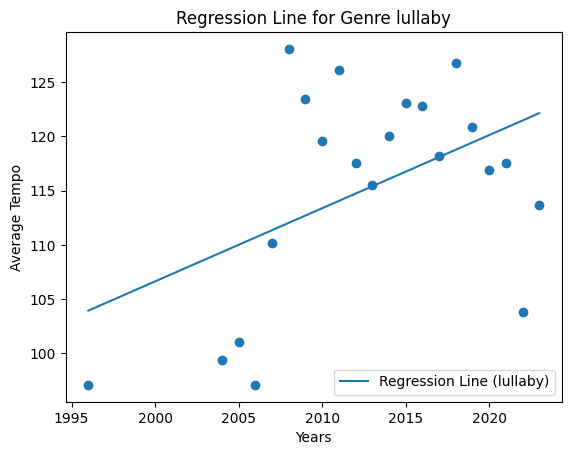

0.6018685326367037
detroit hip hop


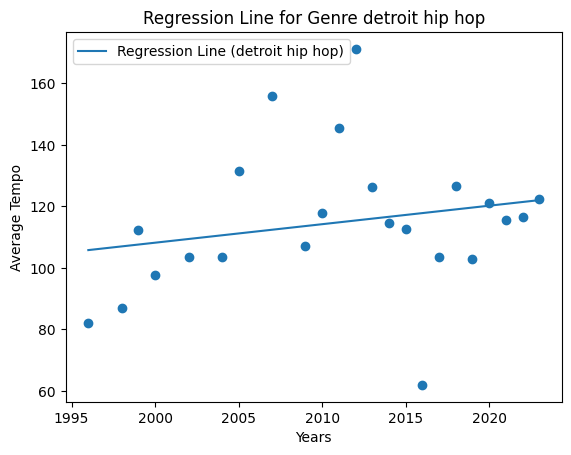

0.7652388422312161
electro


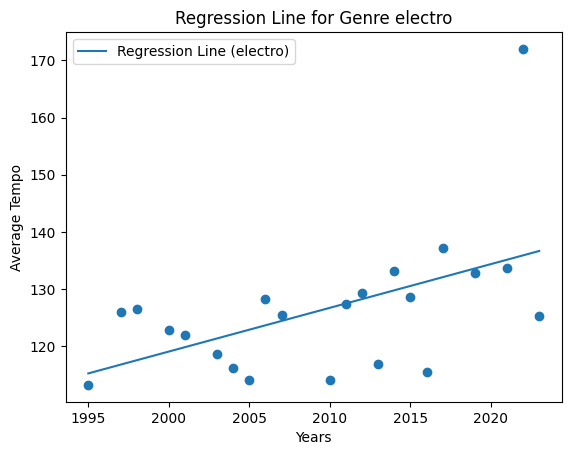

0.7155800555980649
new orleans rap


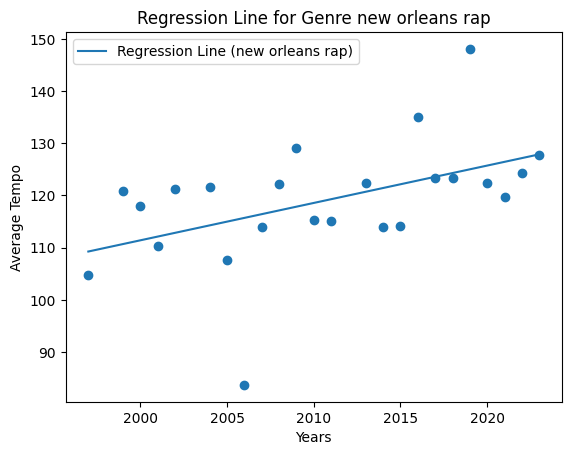

0.6715021908321787
southern hip hop


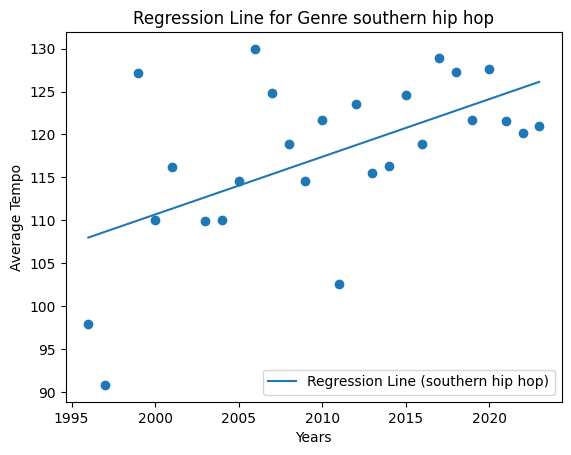

0.6953692610687839
queens hip hop


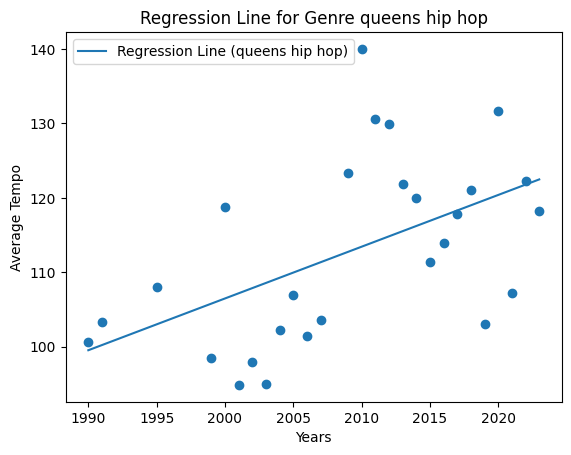

0.7894301968148207
pop rap


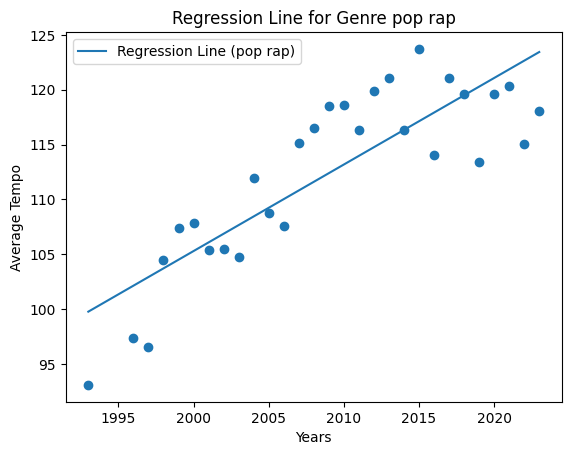

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

filtered_data = [entry for entry in result_query10 if len(entry['evolution']) > 20]

genres_with_changes = []
for genre_data in filtered_data:
    genre_id = genre_data['_id']
    evolution_data = genre_data['evolution']
    tempos = np.array([entry['average_tempo'] for entry in evolution_data])
    years = np.array([entry['year'] for entry in evolution_data]).reshape(-1, 1)


    if ((None in years) == False):
        model = LinearRegression().fit(years, tempos)
        coefficient = model.coef_[0]
        if(abs(coefficient) > 0.6):
            print(coefficient)
            print(genre_id)
            genres_with_changes = np.append(genres_with_changes, genre_id)
            plt.figure()
            plt.scatter(years, tempos)
            plt.plot(years, model.predict(years), label=f'Regression Line ({genre_id})')


            plt.xlabel('Years')
            plt.ylabel('Average Tempo')
            plt.title(f'Regression Line for Genre {genre_id}')
            plt.legend()
            plt.show()

The genres with significative changes in the bpm over the years are:

In [ ]:
genres_with_changes

array(['lullaby', 'detroit hip hop', 'electro', 'new orleans rap',
       'southern hip hop', 'queens hip hop', 'pop rap'], dtype='<U32')

Can be also noticed how all of them have rised their bpms. Meaning that in new years, the music tend to be at faster paces.

# Query 11
### Average track length per genre

Unfortunately, the "genre" field is related to the artist only, not to the album/track, which would be more accurate.

(By the way, how many genres do we have?)

In [ ]:
uniqueGenresQuery = [
  {
    '$group': {
      '_id': "$genre_0",
    }
  },
  {
    '$group': {
      '_id': True,
      'unique_genres': {'$sum': 1}
    }
  }
]

result_uniqueGenresQuery = list(all.aggregate(uniqueGenresQuery))

In [ ]:
result_uniqueGenresQuery

[{'_id': True, 'unique_genres': 3009}]

In [ ]:
query11 = [
  {
    '$group': {
      '_id': "$genre_0",
      'average_track_length': {'$avg': "$duration_ms"}
    }
  },
  {
    '$project': {
      '_id': 0,
      'genre': "$_id",
      'average_track_length': 1
    }
  },
  {
    '$facet': {
        "shortest100": [
            { '$sort': { "average_track_length": 1 } },
            { '$limit': 100 }
        ],
        "longest100": [
            { '$sort': { "average_track_length": -1 } },
            { '$limit': 100 }
        ]
    }
  }
]

result_query11 = list(all.aggregate(query11))

In [ ]:
display_inner_results(result_query11, True)

shortest100

{'average_track_length': 7882.4, 'genre': 'sound effects'}
{'average_track_length': 29568.317073170732, 'genre': 'ringtone'}
{'average_track_length': 59256.0, 'genre': 'cruise'}
{'average_track_length': 61558.42857142857, 'genre': 'birthday'}
{'average_track_length': 66968.65384615384, 'genre': 'hauntology'}
{'average_track_length': 68000.0, 'genre': 'deep dance pop'}
{'average_track_length': 69782.04761904762, 'genre': 'nordic soundtrack'}
{'average_track_length': 74288.0, 'genre': 'russian viral rap'}
{'average_track_length': 75696.0, 'genre': 'japanoise'}
{'average_track_length': 79004.0, 'genre': 'hypnagogic pop'}
{'average_track_length': 80184.6, 'genre': 'plena uruguaya'}
{'average_track_length': 82726.1, 'genre': 'bachchon ke geet'}
{'average_track_length': 83465.11627906977, 'genre': 'german romanticism'}
{'average_track_length': 87637.83636363636, 'genre': 'british electroacoustic'}
{'average_track_length': 88961.56521739131, 'genre': 'bath indie'}
{'average_track

Funnily enough, there exist genres like "sound effects" and "ringtone".
Anyway, it seems like the shortest tracks come from genres like punk or are related to "virality" at first sight, while the longest ones come from classical music.
Let's explore deeper!

In [ ]:
shortest100 = [entry['shortest100'] for entry in result_query11]
shortest100 = shortest100[0]
longest100 = [entry['longest100'] for entry in result_query11]
longest100 = longest100[0]
shortest_genres = [entry['genre'] for entry in shortest100]
longest_genres = [entry['genre'] for entry in longest100]

In [ ]:
shortest_genres

In [ ]:
longest_genres

In [ ]:
from collections import Counter

# Concatenate all strings into a single space-separated string
shortest_genres_text = ' '.join(shortest_genres)

# Split the combined string into a list of words
shortest_genres_words = shortest_genres_text.lower().split()

# Use Counter to count the frequency of each word
shortest_genres_word_frequency = Counter(shortest_genres_words)

print('Word frequencies in the list of the 100 shortest genres:\n')

# Print the words ordered by frequencies in descending order
for word, frequency in shortest_genres_word_frequency.most_common():
    if frequency >= 3:
        print(f'"{word}" appears {frequency} times.')

print('')

# Concatenate all strings into a single space-separated string
longest_genres_text = ' '.join(longest_genres)

# Split the combined string into a list of words
longest_genres_words = longest_genres_text.lower().split()

# Use Counter to count the frequency of each word
longest_genres_word_frequency = Counter(longest_genres_words)

print('Word frequencies in the list of the 100 longest genres:\n')

# Print the words ordered by frequencies in descending order
for word, frequency in longest_genres_word_frequency.most_common():
    if frequency >= 3:
        print(f'"{word}" appears {frequency} times.')

Word frequencies in the list of the 100 shortest genres:

"indie" appears 8 times.
"rap" appears 7 times.
"pop" appears 5 times.
"hip" appears 5 times.
"hop" appears 5 times.
"russian" appears 4 times.
"hardcore" appears 4 times.
"musica" appears 4 times.
"music" appears 4 times.
"german" appears 3 times.
"beats" appears 3 times.
"japanese" appears 3 times.
"phonk" appears 3 times.
"children's" appears 3 times.
"kazakh" appears 3 times.
"punk" appears 3 times.

Word frequencies in the list of the 100 longest genres:

"house" appears 9 times.
"classical" appears 8 times.
"progressive" appears 7 times.
"techno" appears 6 times.
"trance" appears 6 times.
"pop" appears 5 times.
"jazz" appears 5 times.
"industrial" appears 3 times.
"contemporary" appears 3 times.
"swedish" appears 3 times.
"rock" appears 3 times.
"electronic" appears 3 times.
"folk" appears 3 times.


One of the expected genres with the shortest tracks is indeed hardcore punk, but we can go in the opposite direction and find music for children too! The other results of more common genres (indie/rap/pop/beats/phonk) are possibly given by the emerging of artists producing tracks to be used in viral TikTok contents.
On the other hand, we have subgenres coming from the (relatively) new electronic music world (house/techno/trance/industrial) and from the (relatively) old world of jazz and classical music.

In [ ]:
# If you want to get the frequency of a specific word, you can do
specified_word = "hardcore"
specified_word_frequency = word_frequency[specified_word.lower()]
print(f'The word "{specified_word}" appears {specified_word_frequency}

### Alternate version w/ unwind operator
We take into account all the (sub)genres each artist is related to; then, we take the average track lengths shorter than 2m15s and longer than 6m30s only.

In [ ]:
query11bis = [
  {
    '$unwind': {
      'path': "$artist_genres"
    }
  },
  {
    '$group': {
      '_id': "$artist_genres",
      'average_track_length': {'$avg': "$duration_ms"}
    }
  },
  {
    '$project': {
      '_id': 0,
      'genre': "$_id",
      'average_track_length': 1
    }
  },
  {
    '$facet': {
        "shortest": [
            { '$sort': { "average_track_length": 1 } },
            { '$match': {"average_track_length": {"$lt": 135000}} }
        ],
        "longest": [
            { '$sort': { "average_track_length": -1 } },
            { '$match': {"average_track_length": {"$gt": 390000}} }
        ]
    }
  }
]

result_query11bis = list(all.aggregate(query11bis))

In [ ]:
display_inner_results(result_query11bis, True)

shortest

{'average_track_length': 29568.317073170732, 'genre': 'ringtone'}
{'average_track_length': 60938.0, 'genre': 'vintage hollywood'}
{'average_track_length': 61558.42857142857, 'genre': 'birthday'}
{'average_track_length': 62262.4081632653, 'genre': 'sound effects'}
{'average_track_length': 67542.23076923077, 'genre': 'slash punk'}
{'average_track_length': 68000.0, 'genre': 'deep dance pop'}
{'average_track_length': 74288.0, 'genre': 'russian viral rap'}
{'average_track_length': 75696.0, 'genre': 'noise'}
{'average_track_length': 75696.0, 'genre': 'japanoise'}
{'average_track_length': 79004.0, 'genre': 'hypnagogic pop'}
{'average_track_length': 80184.6, 'genre': 'plena uruguaya'}
{'average_track_length': 82519.75, 'genre': 'ragga jungle'}
{'average_track_length': 82726.1, 'genre': 'bachchon ke geet'}
{'average_track_length': 84504.20408163265, 'genre': 'vintage french electronic'}
{'average_track_length': 87514.85294117648, 'genre': 'electroacoustic composition'}
{'average_track

In [ ]:
shortest = [entry['shortest'] for entry in result_query11bis]
shortest = shortest[0]
longest = [entry['longest'] for entry in result_query11bis]
longest = longest[0]
shortest_genres = [entry['genre'] for entry in shortest]
longest_genres = [entry['genre'] for entry in longest]

In [ ]:
from collections import Counter

# Concatenate all strings into a single space-separated string
shortest_genres_text = ' '.join(shortest_genres)

# Split the combined string into a list of words
shortest_genres_words = shortest_genres_text.lower().split()

# Use Counter to count the frequency of each word
shortest_genres_word_frequency = Counter(shortest_genres_words)

print('Word frequencies in the list of the genres shorter than 2m15s:\n')

# Print the words ordered by frequencies in descending order
for word, frequency in shortest_genres_word_frequency.most_common():
    if frequency >= 3:
        print(f'"{word}" appears {frequency} times.')

print('')

# Concatenate all strings into a single space-separated string
longest_genres_text = ' '.join(longest_genres)

# Split the combined string into a list of words
longest_genres_words = longest_genres_text.lower().split()

# Use Counter to count the frequency of each word
longest_genres_word_frequency = Counter(longest_genres_words)

print('Word frequencies in the list of the genres longer than 6m30s:\n')

# Print the words ordered by frequencies in descending order
for word, frequency in longest_genres_word_frequency.most_common():
    if frequency >= 3:
        print(f'"{word}" appears {frequency} times.')

Word frequencies in the list of the genres shorter than 2m15s:

"rap" appears 8 times.
"classical" appears 6 times.
"punk" appears 5 times.
"indie" appears 5 times.
"hip" appears 5 times.
"hop" appears 5 times.
"russian" appears 4 times.
"musica" appears 4 times.
"rock" appears 4 times.
"japanese" appears 4 times.
"pop" appears 3 times.
"soundtrack" appears 3 times.
"hardcore" appears 3 times.
"beats" appears 3 times.
"lo-fi" appears 3 times.
"phonk" appears 3 times.
"kazakh" appears 3 times.
"jersey" appears 3 times.
"music"" appears 3 times.

Word frequencies in the list of the genres longer than 6m30s:

"classical" appears 13 times.
"house" appears 13 times.
"techno" appears 13 times.
"rock" appears 10 times.
"progressive" appears 10 times.
"metal" appears 10 times.
"trance" appears 8 times.
"pop" appears 7 times.
"deep" appears 7 times.
"black" appears 7 times.
"electronic" appears 6 times.
"ambient" appears 6 times.
"jazz" appears 6 times.
"polish" appears 4 times.
"contemporary" 

We got similar results as before, with the exception of some classical subgenres that now enter in the picture of the shortest ones and the entrance of black metal in the longest ones.

# Query 12
## Multi-genre artists
Which will be the most fluid artists in the genres' space?

In [ ]:
query12 = [
  {
    '$unwind': {
      'path': "$artist_genres"
    }
  },
  {
    '$group': {
      '_id': "$id",
      'artist_name': {"$first": "$name"},
      'genres_count': {'$sum': 1}
    }
  },
  {
    '$project': {
      '_id': 0,
      'artist_name': 1,
      'genres_count': 1
    }
  },
  {
    '$sort': {
      "genres_count": -1
    }
  },
  {
    '$match': {
      "genres_count": {"$gte": 10}
    }
  }
]

result_query12 = list(artists.aggregate(query12))

In [ ]:
result_query12

[{'artist_name': 'The Moody Blues', 'genres_count': 14},
 {'artist_name': 'The Byrds', 'genres_count': 13},
 {'artist_name': 'Allman Brothers Band', 'genres_count': 13},
 {'artist_name': 'Derek & The Dominos', 'genres_count': 13},
 {'artist_name': 'Badfinger', 'genres_count': 12},
 {'artist_name': 'Procol Harum', 'genres_count': 12},
 {'artist_name': 'Emerson, Lake & Palmer', 'genres_count': 12},
 {'artist_name': 'Little Dragon', 'genres_count': 11},
 {'artist_name': 'The Yardbirds', 'genres_count': 11},
 {'artist_name': 'Grouper', 'genres_count': 11},
 {'artist_name': 'The Guess Who', 'genres_count': 11},
 {'artist_name': 'LCD Soundsystem', 'genres_count': 11},
 {'artist_name': 'Jimmy Eat World', 'genres_count': 11},
 {'artist_name': 'Robert Plant', 'genres_count': 10},
 {'artist_name': 'Heart', 'genres_count': 10},
 {'artist_name': 'Arcade Fire', 'genres_count': 10},
 {'artist_name': 'Jeff Beck', 'genres_count': 10},
 {'artist_name': 'Bad Company', 'genres_count': 10},
 {'artist_name

Seems like we have several artists mostly related to experimental genres (as well as rock subgenres)

Some examples:

In [ ]:
result_björk_query = list(artists.find({"name": "Björk"}, {"_id": 0, "name": 1, "artist_genres": 1}))
result_grouper_query = list(artists.find({"name": "Grouper"}, {"_id": 0, "name": 1, "artist_genres": 1}))
result_nin_query = list(artists.find({"name": "Nine Inch Nails"}, {"_id": 0, "name": 1, "artist_genres": 1}))

display_results(result_björk_query)
print('')
display_results(result_grouper_query)
print('')
display_results(result_nin_query)

{'name': 'Björk', 'artist_genres': ['art pop', 'electronica', 'experimental pop', 'experimental vocal', 'icelandic experimental', 'icelandic pop', 'icelandic singer-songwriter', 'metropopolis', 'permanent wave', 'trip hop']}

{'name': 'Grouper', 'artist_genres': ['ambient', 'ambient pop', 'art pop', 'dream pop', 'drone', 'electra', 'experimental ambient', 'experimental pop', 'modern dream pop', 'shoegaze', 'spectra']}

{'name': 'Nine Inch Nails', 'artist_genres': ['alternative metal', 'alternative rock', 'cyberpunk', 'electronic rock', 'industrial', 'industrial metal', 'industrial rock', 'nu metal', 'post-grunge', 'rock']}


# Query 13
## Number of subgenres
We've previously seen that exist 3000+ genres in our database, so how many (possibly useless) subgenres did Spotify create?

(Let's consider 5 main genres for our analysis: punk, jazz, classical, rock, pop)

In [ ]:
query13 = [
  {
    '$unwind': {
      'path': "$artist_genres"
    }
  },
  {
    '$facet': {
        "punk_subgenres": [
            { '$match': {"artist_genres": {"$regex": "punk"}} },
            { '$group': { '_id': "$artist_genres"}},
            { '$project': { '_id': 0, "subgenre": "$_id"}}
        ],
        "punk_subgenres_count": [
            { '$match': {"artist_genres": {"$regex": "punk"}} },
            { '$group': { '_id': "$artist_genres",
                          'duplicated_subgenres_count': {'$sum': 1}}},
            { '$group': { '_id': True,
                          'unique_subgenres_count': {'$sum': 1}}},
            { '$project': { '_id': 0, 'unique_subgenres_count': 1}}
        ],
        "jazz_subgenres": [
            { '$match': {"artist_genres": {"$regex": "jazz"}} },
            { '$group': { '_id': "$artist_genres"}},
            { '$project': { '_id': 0, "subgenre": "$_id"}}
        ],
        "jazz_subgenres_count": [
            { '$match': {"artist_genres": {"$regex": "jazz"}} },
            { '$group': { '_id': "$artist_genres",
                          'duplicated_subgenres_count': {'$sum': 1}}},
            { '$group': { '_id': True,
                          'unique_subgenres_count': {'$sum': 1}}},
            { '$project': { '_id': 0, 'unique_subgenres_count': 1}}
        ],
        "classical_subgenres": [
            { '$match': {"artist_genres": {"$regex": "classical"}} },
            { '$group': { '_id': "$artist_genres"}},
            { '$project': { '_id': 0, "subgenre": "$_id"}}
        ],
        "classical_subgenres_count": [
            { '$match': {"artist_genres": {"$regex": "classical"}} },
            { '$group': { '_id': "$artist_genres",
                          'duplicated_subgenres_count': {'$sum': 1}}},
            { '$group': { '_id': True,
                          'unique_subgenres_count': {'$sum': 1}}},
            { '$project': { '_id': 0, 'unique_subgenres_count': 1}}
        ],
        "rock_subgenres": [
            { '$match': {"artist_genres": {"$regex": "rock"}} },
            { '$group': { '_id': "$artist_genres"}},
            { '$project': { '_id': 0, "subgenre": "$_id"}}
        ],
        "rock_subgenres_count": [
            { '$match': {"artist_genres": {"$regex": "rock"}} },
            { '$group': { '_id': "$artist_genres",
                          'duplicated_subgenres_count': {'$sum': 1}}},
            { '$group': { '_id': True,
                          'unique_subgenres_count': {'$sum': 1}}},
            { '$project': { '_id': 0, 'unique_subgenres_count': 1}}
        ],
        "pop_subgenres": [
            { '$match': {"artist_genres": {"$regex": "pop"}} },
            { '$group': { '_id': "$artist_genres"}},
            { '$project': { '_id': 0, "subgenre": "$_id"}}
        ],
        "pop_subgenres_count": [
            { '$match': {"artist_genres": {"$regex": "pop"}} },
            { '$group': { '_id': "$artist_genres",
                          'duplicated_subgenres_count': {'$sum': 1}}},
            { '$group': { '_id': True,
                          'unique_subgenres_count': {'$sum': 1}}},
            { '$project': { '_id': 0, 'unique_subgenres_count': 1}}
        ]
    }
  }
]

result_query13 = list(artists.aggregate(query13))

In [ ]:
display_inner_results(result_query13, True)

punk_subgenres

{'subgenre': 'protopunk'}
{'subgenre': 'australian garage punk'}
{'subgenre': 'chinese punk'}
{'subgenre': 'canadian pop punk'}
{'subgenre': 'punk blues'}
{'subgenre': 'diy pop punk'}
{'subgenre': 'neon pop punk'}
{'subgenre': 'virginia punk'}
{'subgenre': 'hardcore punk'}
{'subgenre': 'j-punk'}
{'subgenre': 'chinese post-punk'}
{'subgenre': 'japanese pop punk'}
{'subgenre': 'long island punk'}
{'subgenre': 'romanian punk'}
{'subgenre': 'quebec punk'}
{'subgenre': 'acoustic punk'}
{'subgenre': 'egg punk'}
{'subgenre': 'chicago pop punk'}
{'subgenre': 'russian post-punk'}
{'subgenre': 'synth punk'}

punk_subgenres_count

{'unique_subgenres_count': 89}

jazz_subgenres

{'subgenre': 'jazz piano'}
{'subgenre': 'experimental jazz'}
{'subgenre': 'jazz puertorriqueno'}
{'subgenre': 'avant-garde jazz'}
{'subgenre': 'background jazz'}
{'subgenre': 'modern jazz piano'}
{'subgenre': 'jazz trumpet'}
{'subgenre': 'latin jazz'}
{'subgenre': 'nu jazz'}
{'subgenre': 'icelandic jazz'}
{

It is clear that the presence of the majority of the subgenres is due to geographic aspects, which may be a not so meaningful way to make reasonable distictions between very similar genres (e.g. "zambian pop/botswana pop").

# Query 14
## Most duplicated albums
It's not rare to find on Spotify different uniform resource identifiers for the exact same album when artists/labels upload newer versions for different markets. This could potentially lead to an issue as stated by the user below.

![Screenshot%202024-01-04%20141803.png](attachment:Screenshot%202024-01-04%20141803.png)

This was Spotify's first response, soon confirmed.

![Screenshot%202024-01-04%20141828.png](attachment:Screenshot%202024-01-04%20141828.png)

In [ ]:
query14 = [
  {
    '$group': {
      '_id': {"artist": "$artist_id", "album": "$album_id"},
      'artist_name': {"$first": "$artist_0"},
      'album_name': {"$first": "$album_name"},
      'track_count_per_album': {'$sum': 1}
    }
  },
  {
    '$group': {
      '_id': {"artist": "$_id.artist", "album_name": "$album_name"},
      'artist_name': {"$first": "$artist_name"},
      'album_name': {"$first": "$album_name"},
      'copies_count': {'$sum': 1}
    }
  },
  {
    '$project': {
      '_id': 0,
      'artist_name': 1,
      'album_name': 1,
      'copies_count': 1
    }
  },
  {
    '$sort': {
      "copies_count": -1
    }
  },
  {
    '$match': {
      "copies_count": {"$gte": 4}
    }
  }
]

result_query14 = list(all.aggregate(query14))

In [ ]:
result_query14

[{'artist_name': 'Johann Sebastian Bach',
  'album_name': 'Bach: St. John Passion',
  'copies_count': 8},
 {'artist_name': 'Data Punk',
  'album_name': 'Daft Punk Is Dead',
  'copies_count': 8},
 {'artist_name': 'Johann Sebastian Bach',
  'album_name': 'Bach, J.S.: St. John Passion, Bwv 245',
  'copies_count': 6},
 {'artist_name': 'Calvin Harris',
  'album_name': 'Ready For The Weekend',
  'copies_count': 6},
 {'artist_name': 'Johann Sebastian Bach',
  'album_name': 'Bach, J.S.: St. John Passion',
  'copies_count': 6},
 {'artist_name': 'Nicki Minaj',
  'album_name': 'Queen Radio: Volume 1',
  'copies_count': 5},
 {'artist_name': 'Calvin Harris',
  'album_name': 'I Created Disco',
  'copies_count': 5},
 {'artist_name': "Singer's Edge Karaoke",
  'album_name': 'Thank You (Originally Performed By Busta Rhymes, Q-Tip, Kanye West & Lil Wayne) [Karaoke Version]',
  'copies_count': 4},
 {'artist_name': 'Tyga',
  'album_name': 'Careless World: Rise Of The Last King',
  'copies_count': 4},
 {'a

Our friend Data Punk really likes to release its album almost every year :-)

![Immagine%202024-01-04%20153614.png](attachment:Immagine%202024-01-04%20153614.png)

Jokes apart, most of the duplicates come from classical artists, mainstream rap/rock artists and karaoke compilations.

### DISCLAIMER
For The Weeknd, for example, it's not exactly the same identical album: like other mainstream artists, when they release a new single, they throw it into the previous album; for classical music albums, on the other hand, it's about different orchestrations, but we group them based on the name of the work, so it all ends up together.

# Query 15
## Popular artists with namesakes

Among popular artists, who has namesakes whose songs can possibly enter in autogenerated playlists for users (like Release Radar)?

In [ ]:
query15 = [
  {
    '$sort': {
      "artist_popularity": -1
    }
  },
  {
    '$group': {
      '_id': "$name",
      'artist_name': {"$first": "$name"},
      'artist_popularity': {"$first": "$artist_popularity"},
      'namesakes_count': {'$sum': 1}
    }
  },
  {
    '$match': {
      "artist_popularity": {"$gte": 70}
    }
  },
  {
    '$project': {
      '_id': 0,
      'artist_name': 1,
      'namesakes_count': 1
    }
  },
  {
    '$sort': {
      "namesakes_count": -1
    }
  },
  {
    '$match': {
      "namesakes_count": {"$gte": 2}
    }
  }
]

result_query15 = list(artists.aggregate(query15))

In [ ]:
result_query15

[{'artist_name': 'Chris Brown', 'namesakes_count': 8},
 {'artist_name': 'Red Velvet', 'namesakes_count': 6},
 {'artist_name': 'Miguel', 'namesakes_count': 6},
 {'artist_name': 'Sam Smith', 'namesakes_count': 5},
 {'artist_name': 'Future', 'namesakes_count': 4},
 {'artist_name': 'Nirvana', 'namesakes_count': 3},
 {'artist_name': 'Young Thug', 'namesakes_count': 3},
 {'artist_name': 'Drake', 'namesakes_count': 3},
 {'artist_name': 'TWICE', 'namesakes_count': 3},
 {'artist_name': 'Calvin Harris', 'namesakes_count': 3},
 {'artist_name': 'BTS', 'namesakes_count': 3},
 {'artist_name': 'YG', 'namesakes_count': 3},
 {'artist_name': 'Adele', 'namesakes_count': 2},
 {'artist_name': 'Tyga', 'namesakes_count': 2},
 {'artist_name': 'Michael Jackson', 'namesakes_count': 2},
 {'artist_name': 'Gunna', 'namesakes_count': 2},
 {'artist_name': 'Madonna', 'namesakes_count': 2},
 {'artist_name': 'H.E.R.', 'namesakes_count': 2},
 {'artist_name': 'B.o.B', 'namesakes_count': 2}]

Chris Brown has a lot of namesakes! Will they be as popular as him?

In [ ]:
result_chrisbrown_query = list(artists.find({"name": "Chris Brown"}, {"_id": 0, "name": 1, "artist_popularity": 1})
                                      .sort({"artist_popularity": -1}))

In [ ]:
result_chrisbrown_query

[{'name': 'Chris Brown', 'artist_popularity': 86},
 {'name': 'Chris Brown', 'artist_popularity': 14},
 {'name': 'Chris Brown', 'artist_popularity': 10},
 {'name': 'Chris Brown', 'artist_popularity': 1},
 {'name': 'Chris Brown', 'artist_popularity': 0},
 {'name': 'Chris Brown', 'artist_popularity': 0},
 {'name': 'Chris Brown', 'artist_popularity': 0},
 {'name': 'Chris Brown', 'artist_popularity': 0}]

Definitely no.

### BONUS: are there popular artists whose namesake is still sufficiently popular?

In [ ]:
query15_bis = [
  {
    '$match': {
      "artist_popularity": {"$gte": 55}
    }
  },
  {
    '$group': {
      '_id': "$name",
      'artist_name': {"$first": "$name"},
      'namesakes_count': {'$sum': 1}
    }
  },
  {
    '$project': {
      '_id': 0,
      'artist_name': 1,
      'namesakes_count': 1
    }
  },
  {
    '$match': {
      "namesakes_count": {"$gte": 2}
    }
  }
]

result_query15_bis = list(artists.aggregate(query15_bis))

In [ ]:
result_query15_bis

[{'artist_name': 'Maxwell', 'namesakes_count': 2}]

Yes! Let's the the two Maxwells on Spotify ;)

![Screenshot%202024-01-05%20001119.png](attachment:Screenshot%202024-01-05%20001119.png)

![Screenshot%202024-01-05%20001202.png](attachment:Screenshot%202024-01-05%20001202.png)

# Query  16
## Top 100 most prolific artists in the last 10 years
Considering both the tracks where they are the main artists and the ones where they are collaborators, who worked on more songs? (Not considering classical composers)

First of all, who are the most popular artists? What is their popularity score?

In [ ]:
result_popularity_query = list(artists.find({}, {'_id': 0, "name": 1, "artist_popularity": 1})
                                       .sort({"artist_popularity": -1})
                                       .limit(500))

In [ ]:
display_results(result_popularity_query, True, 50)
print('...')

{'name': 'Taylor Swift', 'artist_popularity': 100}
{'name': 'Bad Bunny', 'artist_popularity': 95}
{'name': 'Drake', 'artist_popularity': 95}
{'name': 'The Weeknd', 'artist_popularity': 93}
{'name': 'Travis Scott', 'artist_popularity': 90}
{'name': 'Peso Pluma', 'artist_popularity': 90}
{'name': 'Kanye West', 'artist_popularity': 90}
{'name': 'Lana Del Rey', 'artist_popularity': 89}
{'name': 'Eminem', 'artist_popularity': 89}
{'name': 'Jung Kook', 'artist_popularity': 89}
{'name': 'Ariana Grande', 'artist_popularity': 88}
{'name': 'Future', 'artist_popularity': 88}
{'name': '21 Savage', 'artist_popularity': 88}
{'name': 'KAROL G', 'artist_popularity': 88}
{'name': 'Justin Bieber', 'artist_popularity': 88}
{'name': 'Rihanna', 'artist_popularity': 88}
{'name': 'Junior H', 'artist_popularity': 88}
{'name': 'SZA', 'artist_popularity': 88}
{'name': 'Olivia Rodrigo', 'artist_popularity': 87}
{'name': 'Ed Sheeran', 'artist_popularity': 87}
{'name': 'Billie Eilish', 'artist_popularity': 87}
{'n

A good popularity score for our analysis may be 70.

(No checks for track duplicates)

In [ ]:
import datetime

query16 = [
  {
    '$match': {
      'release_date': {'$gte': datetime.datetime(2013, 1, 1)}
    }
  },
  {
    '$match': {
      "artist_popularity": {"$gte": 70}
    }
  },
  {
    '$unwind': {
      'path': "$artists"
    }
  },
  {
    '$group': {
      '_id': "$artists",
      'artist_name': {"$first": "$artists"},
      'artist_genres': {"$first": "$artist_genres"},
      'track_count': {'$sum': 1}
    }
  },
  {
    '$unwind': {
      'path': "$artist_genres"
    }
  },
  { '$match': {"artist_genres": {'$not': {"$regex": "classical"} } } },
  { '$match': {"artist_genres": {'$not': {"$regex": "baroque"} } } },
  { '$match': {"artist_genres": {'$not': {"$regex": "romantic"} } } },
  { '$match': {"artist_genres": {'$not': {"$regex": "early music"} } } },
  {
    '$group': {
      '_id': "$artist_name",
      'artist_name': {"$first": "$artist_name"},
      'track_count': {"$first": "$track_count"}
    }
  },
  {
    '$project': {
      '_id': 0,
      'artist_name': 1,
      'track_count': 1
    }
  },
  {
    '$sort': {
      "track_count": -1
    }
  },
  { '$limit': 100 }
]

result_query16 = list(all.aggregate(query16))

In [ ]:
display_results(result_query16, True, 50)
print('...')

{'artist_name': 'Chris Brown', 'track_count': 700}
{'artist_name': 'Drake', 'track_count': 700}
{'artist_name': 'Future', 'track_count': 674}
{'artist_name': 'Lil Wayne', 'track_count': 659}
{'artist_name': 'Taylor Swift', 'track_count': 614}
{'artist_name': 'David Guetta', 'track_count': 607}
{'artist_name': 'Young Thug', 'track_count': 527}
{'artist_name': 'Nicki Minaj', 'track_count': 485}
{'artist_name': 'Tiësto', 'track_count': 448}
{'artist_name': 'Tyga', 'track_count': 432}
{'artist_name': 'Eminem', 'track_count': 406}
{'artist_name': 'The Weeknd', 'track_count': 399}
{'artist_name': 'BTS', 'track_count': 384}
{'artist_name': 'Migos', 'track_count': 379}
{'artist_name': 'YG', 'track_count': 371}
{'artist_name': 'Gunna', 'track_count': 363}
{'artist_name': 'Snoop Dogg', 'track_count': 348}
{'artist_name': 'Madonna', 'track_count': 328}
{'artist_name': 'Post Malone', 'track_count': 327}
{'artist_name': 'TWICE', 'track_count': 323}
{'artist_name': 'Demi Lovato', 'track_count': 320}

Drake is the king of keeping his name around, but it's followed soon by many other hitmakers.

### Alternate version: what about unpopular artists?

In [ ]:
import datetime

query16bis = [
  {
    '$match': {
      'release_date': {'$gte': datetime.datetime(2013, 1, 1)}
    }
  },
  {
    '$match': {
      "artist_popularity": {"$lte": 50}
    }
  },
  {
    '$unwind': {
      'path': "$artists"
    }
  },
  {
    '$group': {
      '_id': "$artists",
      'artist_name': {"$first": "$artists"},
      'artist_genres': {"$first": "$artist_genres"},
      'track_count': {'$sum': 1}
    }
  },
  {
    '$unwind': {
      'path': "$artist_genres"
    }
  },
  { '$match': {"artist_genres": {'$not': {"$regex": "classical"} } } },
  { '$match': {"artist_genres": {'$not': {"$regex": "baroque"} } } },
  { '$match': {"artist_genres": {'$not': {"$regex": "romantic"} } } },
  { '$match': {"artist_genres": {'$not': {"$regex": "early music"} } } },
  {
    '$group': {
      '_id': "$artist_name",
      'artist_name': {"$first": "$artist_name"},
      'track_count': {"$first": "$track_count"}
    }
  },
  {
    '$project': {
      '_id': 0,
      'artist_name': 1,
      'track_count': 1
    }
  },
  {
    '$sort': {
      "track_count": -1
    }
  },
  { '$limit': 100 }
]

result_query16bis = list(all.aggregate(query16bis))

In [ ]:
display_results(result_query16bis, True, 50)
print('...')

{'artist_name': 'Sound Healing Center', 'track_count': 4045}
{'artist_name': '"Singers Edge Karaoke"', 'track_count': 1455}
{'artist_name': 'SBI Audio Karaoke', 'track_count': 872}
{'artist_name': 'White Knight Instrumental', 'track_count': 861}
{'artist_name': 'The Karaoke Channel', 'track_count': 828}
{'artist_name': 'Piano Dreamers', 'track_count': 676}
{'artist_name': 'Kentong uk', 'track_count': 667}
{'artist_name': 'Molotov Cocktail Piano', 'track_count': 661}
{'artist_name': 'Modoo bts', 'track_count': 607}
{'artist_name': 'Piano Project', 'track_count': 547}
{'artist_name': 'Musical Creations Karaoke', 'track_count': 536}
{'artist_name': 'Instrumental Rap Hip Hop', 'track_count': 527}
{'artist_name': 'ProSound Karaoke Band', 'track_count': 476}
{'artist_name': 'Hip Hop Type Beat', 'track_count': 473}
{'artist_name': 'Trap House Mafia', 'track_count': 453}
{'artist_name': 'Breezy', 'track_count': 438}
{'artist_name': 'Edgar Allan Poe', 'track_count': 435}
{'artist_name': 'Roq St

Wow, it's full of background/karaoke compilations and cover bands!

# Query 17
## Most common song titles per year (from 2000 on)
Will we see "Intro" everywhere? (Retrieving a top 10 for every year)

In [ ]:
import datetime

query17 = [
  {
    '$match': {
      'release_date': {'$gte': datetime.datetime(2000, 1, 1)}
    }
  },
  {
    '$group': {
      '_id': {'year': {'$year': '$release_date'}, 'title': '$track_name'},
      'year': {"$first": {'$year': '$release_date'}},
      'title': {"$first": "$track_name"},
      'track_count': {"$sum": 1}
    }
  },
  {
    '$sort': {
      "year": -1,
      "track_count": -1
    }
  },
  {
    '$group': {
      '_id': "$year",
      'songs': { '$push': {'year': "$year", 'title': "$title", 'track_count': "$track_count"} }
    }
  },
  {
    '$project': {
      'songs': {
        '$slice': ["$songs", 10]
      }
    }
  },
  {
    '$unwind': {
      'path': "$songs"
    }
  },
  {
    '$sort': {
      "_id": -1,
      "songs.track_count": -1
    }
  },
  {
    '$project': {
      '_id': 0,
      'songs.year': 1,
      'songs.title': 1,
      'songs.track_count': 1
    }
  }
]

result_query17 = list(all.aggregate(query17))

In [ ]:
display_results(result_query17, True, 50)
print('...')

{'songs': {'year': 2023, 'title': 'Intro', 'track_count': 77}}
{'songs': {'year': 2023, 'title': 'Outro', 'track_count': 29}}
{'songs': {'year': 2023, 'title': 'Visions', 'track_count': 18}}
{'songs': {'year': 2023, 'title': 'Alone', 'track_count': 17}}
{'songs': {'year': 2023, 'title': 'Wait', 'track_count': 16}}
{'songs': {'year': 2023, 'title': 'Interlude', 'track_count': 15}}
{'songs': {'year': 2023, 'title': 'Paradise', 'track_count': 15}}
{'songs': {'year': 2023, 'title': 'Velvet', 'track_count': 15}}
{'songs': {'year': 2023, 'title': '7 Islands', 'track_count': 14}}
{'songs': {'year': 2023, 'title': 'Barrio Alto', 'track_count': 14}}
{'songs': {'year': 2022, 'title': 'Intro', 'track_count': 51}}
{'songs': {'year': 2022, 'title': 'Outro', 'track_count': 22}}
{'songs': {'year': 2022, 'title': 'Low', 'track_count': 17}}
{'songs': {'year': 2022, 'title': 'Family', 'track_count': 15}}
{'songs': {'year': 2022, 'title': 'Wetland, Pond, Animals', 'track_count': 15}}
{'songs': {'year': 2

The titles are mostly rather generic, but there are also quite a few fairly known names here and there of famous songs possibly covered by various artists or released many times to make more streams ("Bad Guy/Rap God/Californication/Billie Jean"...).

Let's plot the most common title for every year.

In [ ]:
cleaned_result = [entry['songs'] for entry in result_query17]

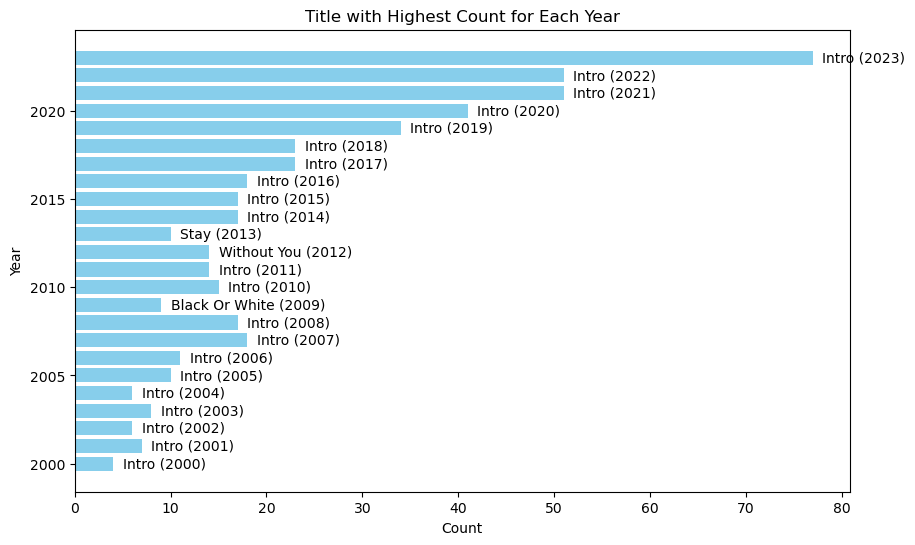

In [ ]:
import matplotlib.pyplot as plt

# Create a dictionary to store the title with the highest count for each year
max_count_per_year = {}

for entry in cleaned_result:
    year = entry["year"]
    title = entry["title"]
    count = entry["track_count"]

    if year not in max_count_per_year or count > max_count_per_year[year]["count"]:
        max_count_per_year[year] = {"title": title, "count": count}

# Extract years, titles, and counts for plotting
years = list(max_count_per_year.keys())
titles = [max_count_per_year[year]["title"] for year in years]
counts = [max_count_per_year[year]["count"] for year in years]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed
bars = ax.barh(years, counts, color='skyblue')

# Add titles to the right of the bars with the year in parentheses
for bar, title, year in zip(bars, titles, years):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, f'{title} ({year})', ha='left', va='center')

ax.set_xlabel('Count')
ax.set_ylabel('Year')
ax.set_title('Title with Highest Count for Each Year')

plt.show()

There's a clear predominance of the unimaginative title "Intro", but it's not the only one!

Moreover, we can see an exponential increase of the number of songs being released in the last years.

# Query 18
## THE bands
How many bands dropping songs between the 60s and the 80s are called "The..."?

In [ ]:
query18 = [
  {
    '$match': {
      'release_date': {'$gte': datetime.datetime(1960, 1, 1)}
    }
  },
  {
    '$match': {
      'release_date': {'$lte': datetime.datetime(1989, 12, 31)}
    }
  },
  {
    '$facet': {
        "the_bands": [
            { '$match': {"artist_0": {"$regex": "^The "}} },
            { '$group': { '_id': "$artist_0"}},
            { '$project': { '_id': 0, "the_name": "$_id"}}
        ],
        "the_bands_count": [
            { '$match': {"artist_0": {"$regex": "^The "}} },
            { '$group': { '_id': {"the_group": "$artist_0", "the_id": "$artist_id"},
                          'the_tracks_count': {'$sum': 1}}},
            { '$group': { '_id': "$_id.the_group",
                          'the_duplicated_count': {'$sum': 1}}},
            { '$group': { '_id': True,
                          'the_unique_count': {'$sum': 1}}},
            { '$project': { '_id': 0, 'the_unique_count': 1}}
#            { '$project': { '_id': 1, 'the_duplicated_count': 1}}
        ]
    }
  }
]

result_query18 = list(all.aggregate(query18))

In [ ]:
result_query18

[{'the_bands': [{'the_name': 'The Box Tops'},
   {'the_name': 'The New Foundations'},
   {'the_name': 'The Black Velvet Band'},
   {'the_name': 'The Cascades'},
   {'the_name': 'The Guess Who'},
   {'the_name': 'The Smiths'},
   {'the_name': 'The "Evening with Alan Jay Lerner" Company'},
   {'the_name': 'The Busters'},
   {'the_name': 'The Beatles'},
   {'the_name': 'The Soul Children'},
   {'the_name': 'The Soul Stirrers'},
   {'the_name': "The B-52's"},
   {'the_name': 'The Blow Monkeys'},
   {'the_name': 'The Righteous Brothers'},
   {'the_name': 'The Legendary Blues Band'},
   {'the_name': 'The Chi-Lites'},
   {'the_name': 'The Bluegrass Cardinals'},
   {'the_name': 'The Romantics'},
   {'the_name': 'The Kingsmen'},
   {'the_name': 'The Yardbirds'},
   {'the_name': 'The Supremes'},
   {'the_name': 'The My Fair Lady Company'},
   {'the_name': 'The Waitresses'},
   {'the_name': 'The Moody Blues'},
   {'the_name': 'The Temptations'},
   {'the_name': "The St. John's Inspirational Choir

Unfortunately, the legendary "The The" is not present in the database :(

![Screenshot%202024-01-05%20150405.png](attachment:Screenshot%202024-01-05%20150405.png)

# Query 19
## Popular artists who tend to release more singles than albums
Most of the artists are used to release 3/4 singles before the album these singles are taken from is out, but there may be artists who don't follow this "rule": let's see who they are!

In [ ]:
query19 = [
  {
    '$match': {
      "artist_popularity": {"$gte": 70}
    }
  },
  {
    '$group': {
      '_id': "$artist_id",
      'artist_name': {"$first": "$artist_0"},
      'singles_count': {
          '$sum': {
            '$cond': [{'$eq': ['$album_type', "single"]}, 1, 0]
          }
      },
      'total_count': {'$sum': 1}
    }
  },
  {
    '$project': {
      '_id': 0,
      'artist_name': 1,
      'singles_percentage': {
        '$multiply': [{'$divide': ['$singles_count', '$total_count']}, 100]
      },
      'total_count': 1
    }
  },
  {
    '$sort': {
      "singles_percentage": -1,
      "total_count": -1
    }
  },
  {
    '$match': {
      "total_count": {"$gte": 10}
    }
  },
]

result_query19 = list(all.aggregate(query19))

In [ ]:
display_results(result_query19, True, 50)

{'artist_name': 'Joel Corry', 'total_count': 38, 'singles_percentage': 100.0}
{'artist_name': 'Kim Petras', 'total_count': 31, 'singles_percentage': 100.0}
{'artist_name': 'Charlie Puth', 'total_count': 31, 'singles_percentage': 100.0}
{'artist_name': 'Clean Bandit', 'total_count': 27, 'singles_percentage': 100.0}
{'artist_name': 'DJ Khaled', 'total_count': 24, 'singles_percentage': 100.0}
{'artist_name': 'Coldplay', 'total_count': 23, 'singles_percentage': 100.0}
{'artist_name': 'Kygo', 'total_count': 19, 'singles_percentage': 100.0}
{'artist_name': 'Martin Garrix', 'total_count': 18, 'singles_percentage': 100.0}
{'artist_name': 'DJ Snake', 'total_count': 16, 'singles_percentage': 100.0}
{'artist_name': 'Ed Sheeran', 'total_count': 14, 'singles_percentage': 100.0}
{'artist_name': 'Diplo', 'total_count': 14, 'singles_percentage': 100.0}
{'artist_name': 'Rita Ora', 'total_count': 13, 'singles_percentage': 100.0}
{'artist_name': 'Flo Rida', 'total_count': 12, 'singles_percentage': 100.0}

Although the database is incomplete (Ed Sheeran has released several albums, as well as Coldplay, for example), the trend is pretty clear: the ones who tend to release more singles than albums are DJs or newly-born popstars.

# Query 20
## Most energetic punk subgenres
"Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale."

For our analysis, we will take into consideration only those punk subgenres that may be safely considered the "main" ones.

In [ ]:
query20 = [
  {
    "$unwind": "$artist_genres",
  },
  {
    '$match': {
      "artist_genres": {"$regex": "punk"}
    }
  },
  {
    "$group": {
      "_id": "$artist_genres",
      "average_energy": {"$avg": "$energy"},
      "average_popularity": {"$avg": "$track_popularity"},
      "track_count": {"$sum": 1}
    },
  },
  {
    '$match': {
      "track_count": {"$gte": 60}
    }
  },
  {
    '$match': {
      "average_popularity": {"$gte": 10}
    }
  },
  {
    '$project': {
      '_id': 0,
      'subgenre': "$_id",
      'average_energy': 1,
    }
  },
  {
    '$sort': {
      "average_energy": -1,
    }
  },
]

result_query20 = list(all.aggregate(query20))

In [ ]:
result_query20

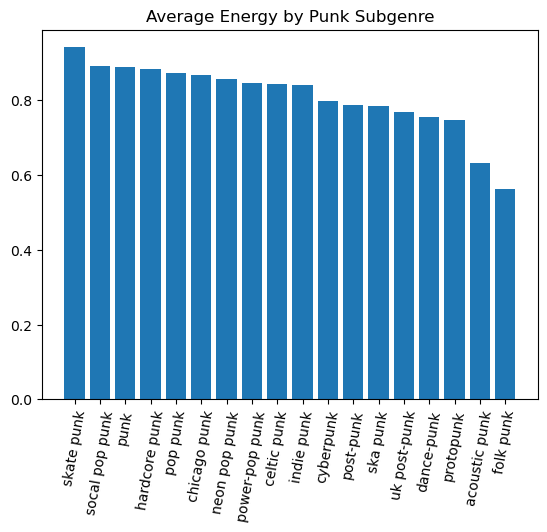

In [ ]:
# Extracting subgenres and average energies from the data
subgenres = [entry["subgenre"] for entry in result_query20]
average_energies = [entry["average_energy"] for entry in result_query20]

# Plotting
plt.bar(subgenres, average_energies)
plt.title('Average Energy by Punk Subgenre')
plt.xticks(rotation=80)
plt.show()

The resuts are pretty reasonable: the top-half is filled with pop-punk subgenres, which are usually upbeat, and the more aggressive harcore punk; then we find the celtic punk of The Pogues, still really enegertic, and, as we proceed, the moodier post-punk; finally, acousticness takes over and, according to the score, energy disappears.